In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tarfile
import random
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Read in the Data

For this activity, we will use the data from the Herbarium Challenge described in [Little et al. (2020)](https://bsapubs.onlinelibrary.wiley.com/doi/pdf/10.1002/aps3.11365).

The data are a set of images of herbarium specimens labeled by species.

The training data consists of 34225 images and labels. The labels indicate to which of 683 species the imaged specimens belong. The validation data consists of 2679 images and labels.

In the interest of time, we will only consider the five species with the mostimages. So, our training data will consist of 2575 images and labels and our validation data will consist of 174 images and labels.

We will not use testing data here, because the authors did not provide the labels. Imagine that the authors will evaluate your model on the testing data once you turn a finalized model over to them.

In [17]:
# Step 1: Define parameters
image_height = 150
image_width = 150
num_classes = 5

# Step 2: Define data preprocessing function
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_height, image_width])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

with tarfile.open('small-train-top5.tar.gz', 'r:gz') as tar:
    tar.extractall(path="small-train-top5")

with tarfile.open('small-validation-top5.tar.gz', 'r:gz') as tar:
    tar.extractall(path="small-validation-top5")

# Step 3: Load and preprocess the training dataset
train_data_dir = './small-train-top5/'

train_image_paths = []
train_labels = []
label_count = {}  # Dictionary to store the count of images for each label

train_categories = os.listdir(train_data_dir)
for category in train_categories:
    category_path = os.path.join(train_data_dir, category)
    if os.path.isdir(category_path):
        label = int(category)
        image_files = os.listdir(category_path)
        label_count[label] = len(image_files)  # Count the number of images for this label
        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)
            train_image_paths.append(image_path)
            train_labels.append(label)

# Create a mapping from original labels to new labels (continuous integers starting from 0)
label_mapping = {label: idx for idx, label in enumerate(set(train_labels))}

# Map the original labels to new labels in the training dataset
mapped_train_labels = [label_mapping[label] for label in train_labels]

# Create TensorFlow Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, mapped_train_labels))
train_dataset = train_dataset.map(preprocess_image)

# Step 4: Load and preprocess the validation dataset
val_data_dir = './small-validation-top5/'

val_image_paths = []
val_labels = []

val_categories = os.listdir(val_data_dir)
for category in val_categories:
    category_path = os.path.join(val_data_dir, category)
    if os.path.isdir(category_path):
        label = int(category)
        image_files = os.listdir(category_path)
        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)
            val_image_paths.append(image_path)
            val_labels.append(label)

# Map the original labels to new labels in the validation dataset
mapped_val_labels = [label_mapping[label] for label in val_labels]

# Create TensorFlow Dataset for validation data
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, mapped_val_labels))
val_dataset = val_dataset.map(preprocess_image)

# print size of datasets
print('Validation set: %s' % len(val_labels))
print('Training set: %s' % len(train_labels))
print("Range of labels in train_labels:", min(mapped_train_labels), "to", max(mapped_train_labels))


Validation set: 174
Training set: 2575
Range of labels in train_labels: 0 to 4


# Look at some images

We will view a fiew images from the training dataset.

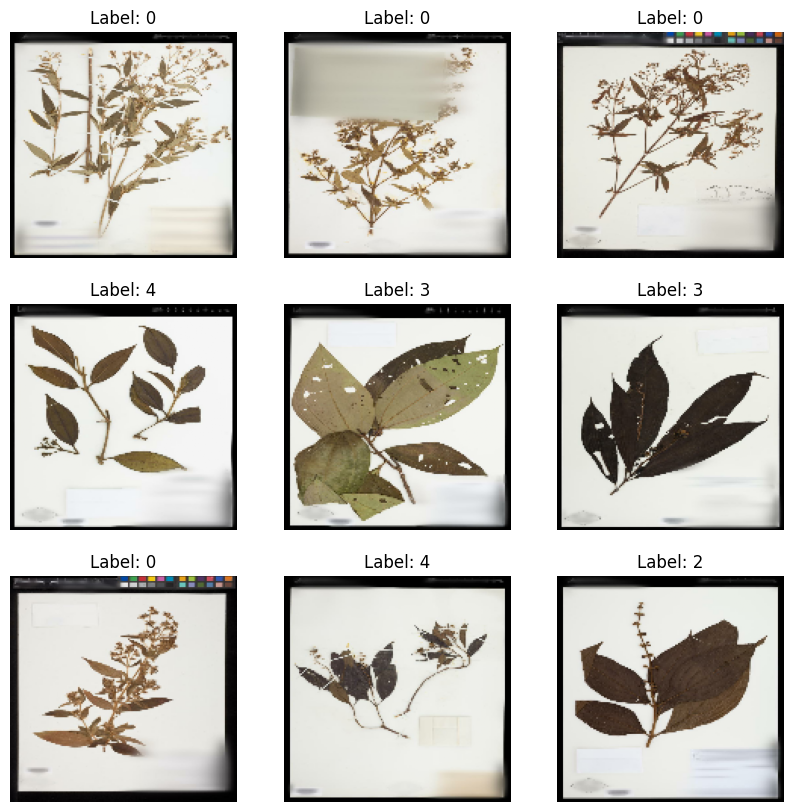

In [13]:
# Shuffle temporarily to get random samples
sampled_dataset = train_dataset.shuffle(buffer_size=len(train_image_paths))

# Take 9 random samples
sampled_dataset = sampled_dataset.take(9)

# Plot
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(sampled_dataset):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())  # Convert tensor to numpy
    plt.title(f'Label: {label.numpy()}')
    plt.axis('off')
plt.show()


# Build and train the CNN

Below we define and train a CNN. We evaluate accuracy on a training and validation dataset.

**Change**: Change details of the CNN based on the questions asked, and assess the impacts of these changes on accuracy.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 72, 72, 18)     │         5,202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 36, 36, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 23328)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,499,479 (5.72 MB)

 Trainable params: 1,499,479 (5.72 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.2578 - loss: 1.7217 - val_accuracy: 0.4138 - val_loss: 1.2681
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.5363 - loss: 1.1564 - val_accuracy: 0.6207 - val_loss: 1.0020
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.6841 - loss: 0.8216 - val_accuracy: 0.6667 - val_loss: 0.8180
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.8016 - loss: 0.5261 - val_accuracy: 0.6839 - val_loss: 0.7962
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.8659 - loss: 0.3527 - val_accuracy: 0.6322 - val_loss: 0.8114


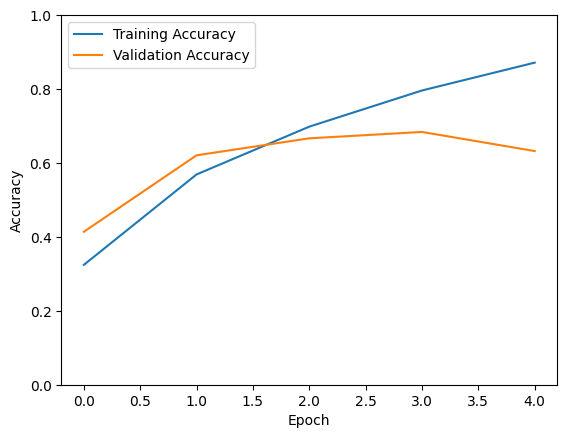

In [21]:
# Step 3: Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(18, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes)
])

print(model.summary())

# Step 5: Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Step 6: Train the model with training data
batch_size = 32  # or any number you prefer

train_dataset_batched = train_dataset.shuffle(buffer_size=len(train_image_paths)).batch(batch_size)
val_dataset_batched = val_dataset.batch(batch_size)
history = model.fit(train_dataset_batched, epochs=5, validation_data=val_dataset_batched)

# Step 7: Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.legend()
plt.show()

# 6990 Only
Add code to create confusion matrices for your validation and training data. Look back at the FCNN activity for help.

In [ ]:
# Predictions on training and validation data
train_dataset_temp_batch = train_dataset.batch(batch_size=batch_size)
val_dataset_temp_batch = val_dataset.batch(batch_size=batch_size)
y_train_probs = model.predict(train_dataset_temp_batch)
y_val_probs = model.predict(val_dataset_temp_batch)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_train_pred =  np.argmax(y_train_probs, axis=1)
y_val_pred = np.argmax(y_val_probs, axis=1)

# compute and plot confusion matrices

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets